# BehaviorAnalysis_Visualization_CutOut-Importance

前処理後のinputに対して円状のマスク(0で満たされている)を入れた場合にどれだけ精度が下がるかを見ることで、

そのピクセルでの重要度(Importance)を推測する。

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tifffile
def load_image(filename):
    raw_image = tifffile.imread(filename)
    image1 = raw_image - raw_image.mean(axis=0)
    
    f_size=1000
    filter_ = np.ones(f_size)/f_size
    movemean = np.apply_along_axis(lambda m: np.convolve(m, filter_, mode='same'), axis=0, arr=image1) 
    image =  image1 - movemean
    
    ax = image.shape
    X_tmp = (image - image.mean()) / image.std() # Normalize
    #X_tmp = (image - image.min()) / (image.max() - image.min()) # MINI-MAX
    X = np.zeros([ax[0] - 2, 3, ax[1], ax[2]])
    X[:,0,:,:] = X_tmp[:-2, :, :]
    X[:,1,:,:] = X_tmp[1:-1, :, :]
    X[:,2,:,:] = X_tmp[2:, :, :]
    return X

In [3]:
FRAME_NUM = 18000 #動画のフレームの長さ
THR = 0.5 #runしているかどうかの判別の閾値

def load_label(filename):
    behave = pd.read_table(filename)
    Y = np.zeros([FRAME_NUM - 2, 1])
    for i in range(FRAME_NUM - 2):
        Speed = np.asarray(behave.Speed)
        idx = np.abs(np.asarray(behave.Frame) - (i+2)).argmin() # nearest value index
        Y[i,:] = Speed[idx] > THR
    print('positive proportion: {:.2}'.format(Y.sum() / FRAME_NUM))
    return Y

In [4]:
import glob
folder = 'data/'
data_tmp = glob.glob(folder + '*.tif')
data = []
for i in data_tmp:
    a = i.lstrip(folder).rstrip('.tif')
    data.append(a)

In [5]:
# 前半の半分をtraining、その後の1/4をvalidation、残りをinference
print(len(data))
train_len = len(data)//2
print(train_len)
valid_len = len(data)//2 + len(data)//4
print(valid_len)

43
21
31


In [6]:
# データ振り分け
train_data = data[:train_len]
print(train_data)
valid_data = data[train_len:valid_len]
print(valid_data)
infer_data = data[valid_len:]
print(infer_data)

['20180206_Emx1G6_non_1', '20180208_Emx1G6_non_1', '20180216_Emx1G6_R_1', '20180126_Emx1G6_LR_1', '20180207_Emx1G6_R_1', '20180201_Emx1G6_LR_1', '20180205_Emx1G6_R_1', '20180131_Emx1G6_R_1', '20180215_Emx1G6_LR_1', '20180131_Emx1G6_LR_1', '20180126_Emx1G6_R_1', '20180209_Emx1G6_R_1', '20180125_Emx1G6_non_1', '20180129_Emx1G6_non_1', '20180130_Emx1G6_R_1', '20180209_Emx1G6_LR_1', '20180214_Emx1G6_R_1', '20180215_Emx1G6_R_1', '20180130_Emx1G6_non_1', '20180208_Emx1G6_LR_1', '20180213_Emx1G6_R_1']
['20180207_Emx1G6_non_1', '20180130_Emx1G6_LR_1', '20180214_Emx1G6_non_1', '20180213_Emx1G6_LR_1', '20180207_Emx1G6_LR_1', '20180214_Emx1G6_LR_1', '20180216_Emx1G6_non_1', '20180206_Emx1G6_LR_1', '20180131_Emx1G6_non_1', '20180129_Emx1G6_R_1']
['20180216_Emx1G6_LR_1', '20180125_Emx1G6_R_1', '20180126_Emx1G6_non_1', '20180206_Emx1G6_R_1', '20180125_Emx1G6_LR_1', '20180213_Emx1G6_non_1', '20180208_Emx1G6_R_1', '20180209_Emx1G6_non_1', '20180129_Emx1G6_LR_1', '20180201_Emx1G6_non_1', '20180215_Emx1

# Calculation

In [7]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [8]:
# seed固定
import os, random
SEED = 2020
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [9]:
VER = 'b0'
from efficientnet_pytorch import EfficientNet
cnn = EfficientNet.from_pretrained('efficientnet-'+VER, num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [10]:
BATCH_SIZE = 64
SEQ_SIZE = 10
FEATURE_SIZE = 1280 # efficient-net b0の時は1280
LSTM_UNITS = 128

class CNN_LSTM(nn.Module):
    def __init__(self,cnn):
        super(CNN_LSTM, self).__init__()
        self.cnn = cnn.cuda()
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(FEATURE_SIZE, LSTM_UNITS, num_layers=2, dropout=0.2, batch_first=True)
        self.linear_out = nn.Linear(LSTM_UNITS, 1)

    def forward(self, x):
        x = x.reshape(-1, 3, x.shape[3], x.shape[4]) # (batch, channel, size1, size2)
        with torch.no_grad():
            embedding = self.cnn.extract_features(x)
            embedding = self.avgpool(embedding)
            embedding = embedding.reshape(-1, SEQ_SIZE, FEATURE_SIZE) # (batch, seq_len, input_size)
        self.lstm.flatten_parameters()
        o_lstm, _ = self.lstm(embedding)
        output = self.linear_out(o_lstm[:,-1,:])
        return output

In [11]:
model = CNN_LSTM(cnn)
model.cuda()

CNN_LSTM(
  (cnn): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project

In [12]:
from tqdm.auto import tqdm
class trainer:
    def __init__(self):
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.model = model
        self.lr = 1e-3
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr) 
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100, eta_min=self.lr * 0.1)
        
    def batch_train(self, batch_imgs, batch_labels, batch_idx):
        batch_imgs, batch_labels = batch_imgs.cuda().float(), batch_labels.cuda().float()
        predicted = self.model(batch_imgs)
        loss = self.loss_fn(predicted.float().reshape(-1), batch_labels.reshape(-1))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item(), predicted
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            loss, predicted = self.batch_train(imgs, labels, batch_idx)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step()
        return current_loss_mean
    
    def valid_epoch(self, loader):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        current_accuracy_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                batch_imgs = imgs.cuda().float()
                batch_labels = labels.cuda().float()
                predicted = self.model(batch_imgs)
                loss = self.loss_fn(predicted.float().reshape(-1),batch_labels.float().reshape(-1)).item()
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
                output = (torch.sigmoid(predicted)>0.5).float()
                accuracy = (output == batch_labels).float().mean()
                current_accuracy_mean = (current_accuracy_mean * batch_idx + accuracy) / (batch_idx + 1)
                tqdm_loader.set_description('loss: {:.4} acc:{:.4}'.format(current_loss_mean, current_accuracy_mean))
        return current_loss_mean
        
    def predict(self, batch_imgs):
        self.model.eval()
        batch_imgs = batch_imgs.cuda().float()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
        return torch.sigmoid(predicted)

In [13]:
from torch.utils.data import DataLoader
Trainer = trainer()
Trainer.model.load_state_dict(torch.load("models/cnn_lstm_best_{}.pth".format(VER)))

<All keys matched successfully>

In [14]:
class ImageDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0] - SEQ_SIZE)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx:idx+SEQ_SIZE, :, :, :], dtype=torch.float)
        y = torch.tensor(self.targets[idx+SEQ_SIZE, :], dtype=torch.float)            
        return x, y

In [15]:
SIZE = 128 # 画像のサイズ(2の累乗)
RADIUS = 16 # カットアウトの半径, =importance計算するピクセル粒度 (２の累乗)

In [16]:
default_mask = np.ones([SIZE, SIZE])
import gc
def inference_1_image(X, Y):
    Y_pred = np.zeros([FRAME_NUM-2, 1])
    Y_true = np.zeros([FRAME_NUM-2, 1])
    
    #平均画像の表示
    plt.imshow(X.mean(axis=0).mean(axis=0), cmap="gray")
    plt.show()
    
    ds_i = ImageDataset(X, Y)
    infe = DataLoader(ds_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=False)
    tqdm_loader = tqdm(infe)
    for idx, (imgs,labels) in enumerate(tqdm_loader):
        bs = labels.shape[0]
        Y_pred[idx*bs:(idx+1)*bs] = Trainer.predict(imgs).cpu()
        Y_true[idx*bs:(idx+1)*bs] = labels
    del X, Y, ds_i, infe, tqdm_loader
    gc.collect();
    return Y_pred, Y_true

In [17]:
import cv2
from sklearn.metrics import roc_auc_score

def calcurate_importance(filename):
    X = load_image(folder + filename + '.tif')
    Y = load_label(folder + filename +'.txt')
    Y_pred, Y_true = inference_1_image(X, Y)
    
    AUC = roc_auc_score(Y_true, Y_pred)
    print('Base AUC: {}'.format(AUC))
    
    score = np.ones([SIZE // RADIUS - 1, SIZE // RADIUS - 1]) * AUC
    for i in range(SIZE // RADIUS - 1):
        for j in range(SIZE // RADIUS - 1):
            tmp = np.ones([SIZE, SIZE])
            mask = cv2.circle(tmp,((i+1)*RADIUS ,(j+1)*RADIUS), RADIUS, 0, -1)
            Y_pred, Y_true = inference_1_image(X * mask, Y)
            AUC = roc_auc_score(Y_true, Y_pred)
            print(AUC)
            score[i,j] = score[i,j] - AUC
    return X.mean(axis=0).mean(axis=0), score.transpose()

positive proportion: 0.26


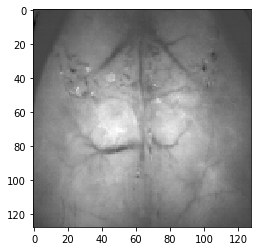


Base AUC: 0.960494697983252


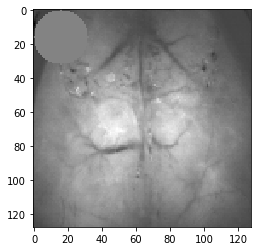


0.9571037244539915


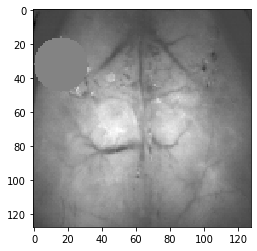


0.95147537234193


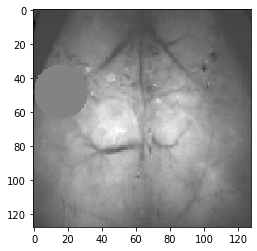


0.9422746729914007


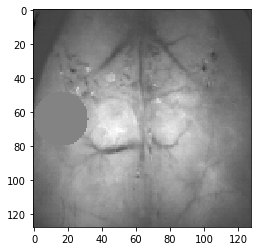


0.9401257883011881


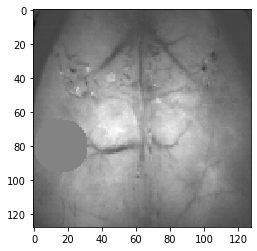


0.9467089714213351


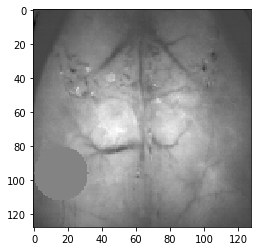


0.9586864533927238


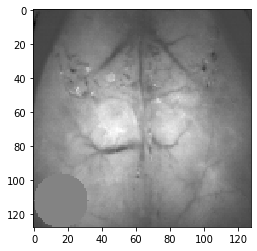


0.957530023346201


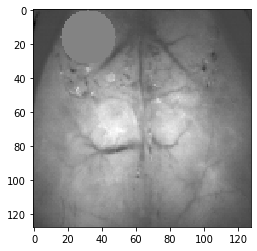


0.9553014812291256


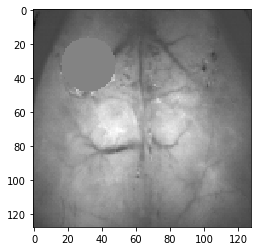


0.949440335900717


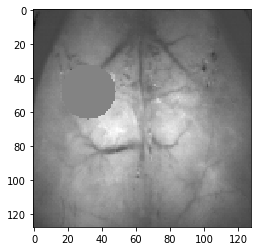


0.9373250486809296


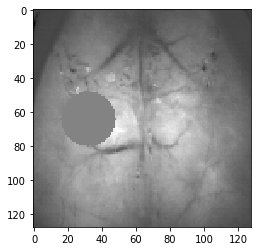


0.9306325324711441


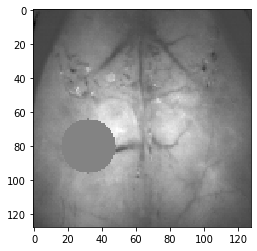


0.9315241189393455


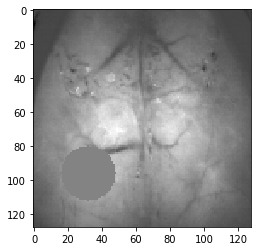


0.9533503265946426


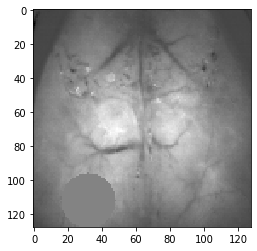


0.9572642670433575


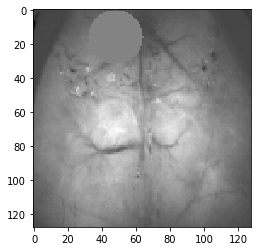


0.9586241135001538


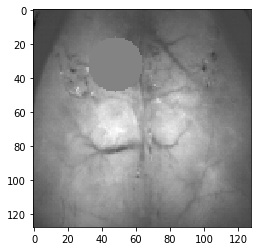


0.9553464793557788


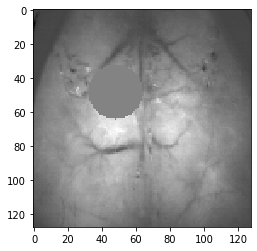


0.9505691742041692


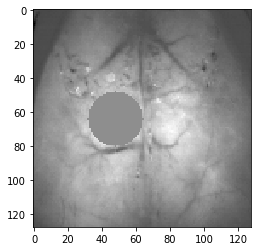


0.9445791731740021


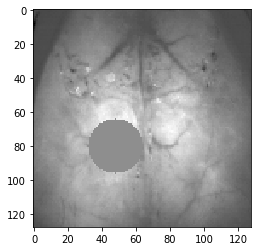


0.9498403919436182


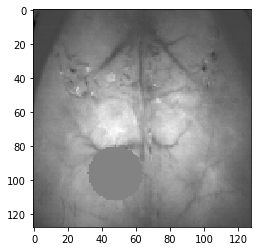


0.9538401527290213


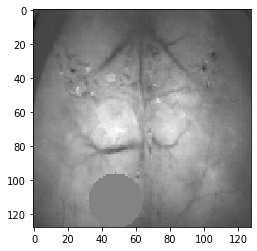


0.9574652279823506


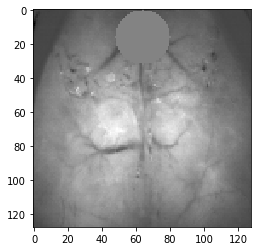


0.9600672682819004


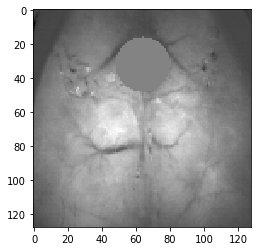


0.9591598181768748


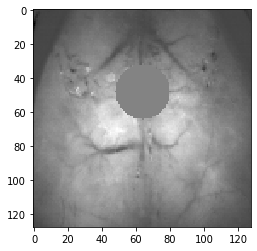


0.9566769086204602


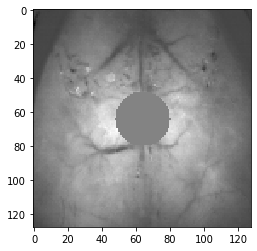


0.9542757323334051


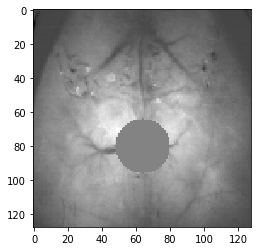


0.9538725584881548


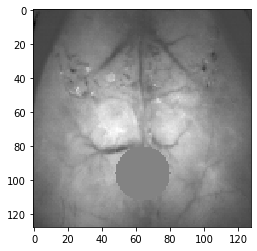


0.9541912931993121


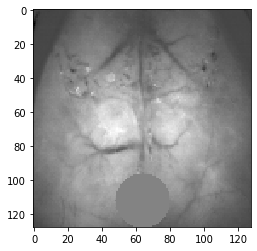


0.9573766129316393


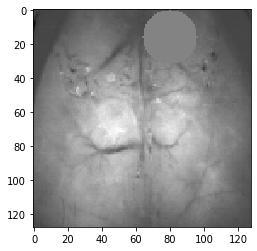


0.9598320519031057


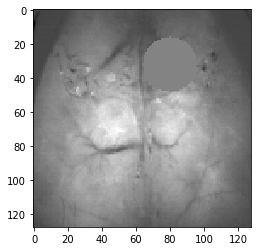


0.9576841284006642


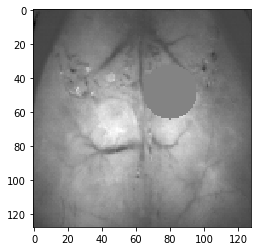


0.9561586587905702


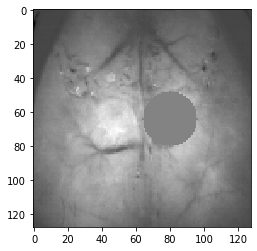


0.9526679802037967


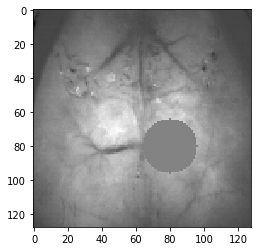


0.9558798901053829


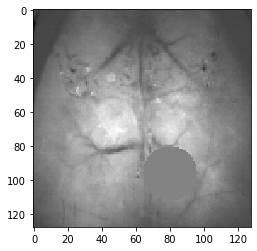


0.9578402285255426


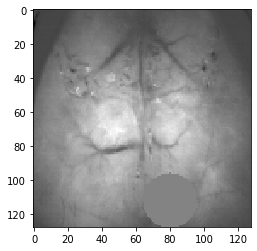


0.9598336834991539


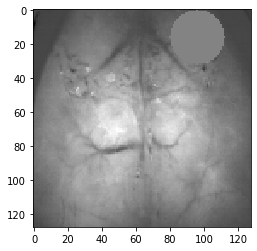


0.9581422272613949


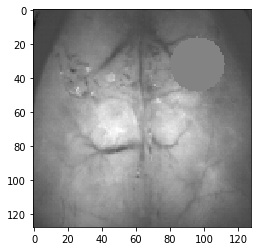


0.9541944110016615


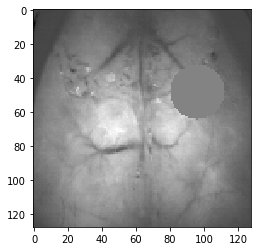


0.9525281314217339


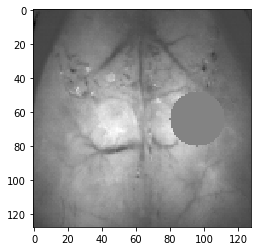


0.9535815124465657


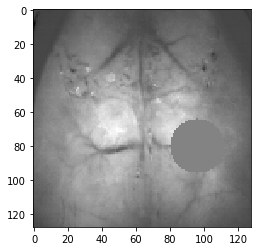


0.9503943591879866


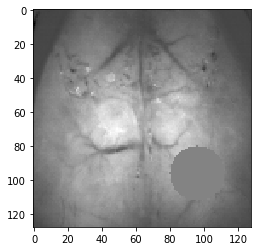


0.9559805078874181


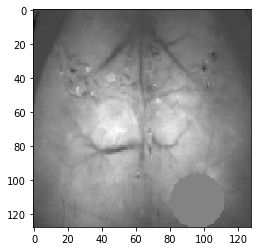


0.96018203733263


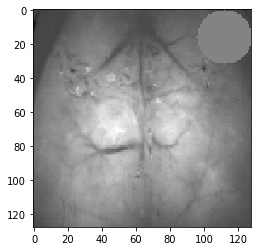


0.9580620852020425


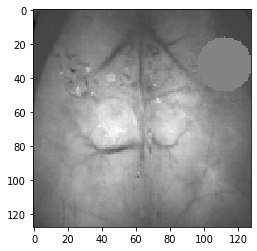


0.9524442253833795


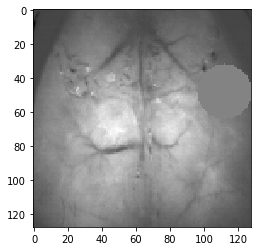


0.9483185974632364


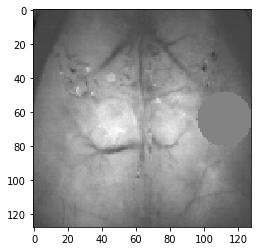


0.950462240045354


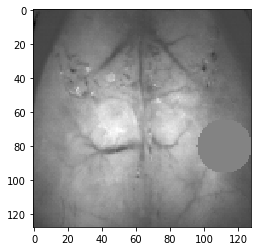


0.9547051005647149


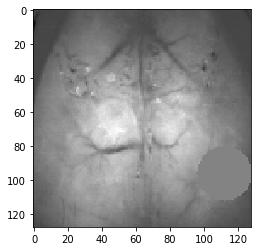


0.958398670543231


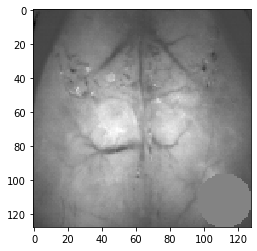


0.9597416275577673


In [18]:
# 画像を指定してimportanceを計算
file = infer_data[2]
img, score = calcurate_importance(file)

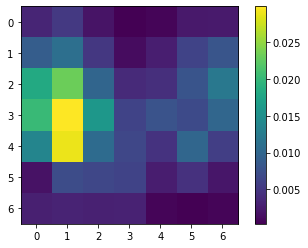

In [22]:
# 結果のimportance mapを表示
plt.imshow(score)
plt.colorbar()
plt.show()

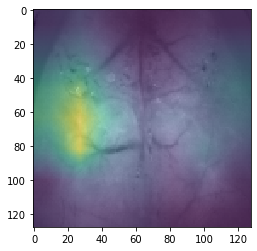

In [23]:
# resizeして入力画像と重ねる
plt.imshow(img, cmap="gray")
plt.imshow(cv2.resize(score, (SIZE, SIZE)), alpha=0.5)
plt.show()